In [1]:
%cd /kaggle/working

/kaggle/working


In [2]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from hydra import compose, initialize
from omegaconf import OmegaConf

from utils.metric import score

In [3]:
def hide_submission(sub_df):
    hide_sub_df = sub_df.clone().with_columns(
        [pl.lit(0.0).alias(f"ptend_q0002_{i}") for i in range(12, 22)]
    )
    return hide_sub_df

In [4]:
base_sub_path = "gs://kaggle-leap/kami/20240610_ensemble_nelder_mead2_lb078544.parquet"
base_sub_df = pl.read_parquet(base_sub_path)
base_sub_df.head()

sample_id,ptend_t_0,ptend_t_1,ptend_t_2,ptend_t_3,ptend_t_4,ptend_t_5,ptend_t_6,ptend_t_7,ptend_t_8,ptend_t_9,ptend_t_10,ptend_t_11,ptend_t_12,ptend_t_13,ptend_t_14,ptend_t_15,ptend_t_16,ptend_t_17,ptend_t_18,ptend_t_19,ptend_t_20,ptend_t_21,ptend_t_22,ptend_t_23,ptend_t_24,ptend_t_25,ptend_t_26,ptend_t_27,ptend_t_28,ptend_t_29,ptend_t_30,ptend_t_31,ptend_t_32,ptend_t_33,ptend_t_34,ptend_t_35,…,ptend_v_31,ptend_v_32,ptend_v_33,ptend_v_34,ptend_v_35,ptend_v_36,ptend_v_37,ptend_v_38,ptend_v_39,ptend_v_40,ptend_v_41,ptend_v_42,ptend_v_43,ptend_v_44,ptend_v_45,ptend_v_46,ptend_v_47,ptend_v_48,ptend_v_49,ptend_v_50,ptend_v_51,ptend_v_52,ptend_v_53,ptend_v_54,ptend_v_55,ptend_v_56,ptend_v_57,ptend_v_58,ptend_v_59,cam_out_NETSW,cam_out_FLWDS,cam_out_PRECSC,cam_out_PRECC,cam_out_SOLS,cam_out_SOLL,cam_out_SOLSD,cam_out_SOLLD
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""test_0""",0.000003,-0.000065,-0.000085,-0.000086,-0.000096,-0.0001,-0.000082,-0.000064,-0.000049,-0.000041,-0.000028,-0.000018,-0.000009,-0.000004,-4.1657e-7,0.000001,0.000006,0.000004,0.000003,-0.000009,0.000009,-0.000003,-0.000012,-0.000016,-0.000015,-0.000013,-0.000016,-0.000018,-0.000023,-0.000031,-0.000037,-0.000032,-0.000023,-0.000018,-0.000017,-0.000015,…,9.3603e-7,0.000002,-4.3578e-7,-0.000002,-0.000001,-6.4969e-7,-8.2227e-7,-0.000003,-7.8813e-7,-5.8951e-7,1.9074e-7,-0.000003,0.000006,0.000001,0.000002,-0.000005,-0.000006,-0.000026,-0.000048,-0.000048,-0.000018,0.000038,0.000043,0.000042,0.000022,0.000012,0.000009,0.000008,4.1996e-7,-0.136167,402.35946,4.6684e-11,4.1327e-10,-0.033577,-0.049489,0.09329,0.212398
"""test_10""",-0.000015,-0.00005,-0.000034,-0.000052,-0.00009,-0.000133,-0.000142,-0.000097,-0.000046,-0.000026,-0.000018,-0.000014,-0.000011,-0.000009,-0.000007,-0.000005,-0.000004,-0.000004,-0.000002,-0.000004,-0.000004,-0.000008,-0.000008,-0.000009,-0.000008,-0.000011,-0.000013,-0.000017,-0.00002,-0.000018,-0.00002,-0.000019,-0.000015,-0.000007,-0.000002,0.000003,…,-4.8681e-7,-3.7356e-7,2.0193e-7,4.7321e-7,3.4525e-7,2.1168e-7,1.7050e-7,6.5687e-8,2.0065e-8,2.7567e-9,1.3472e-7,-8.9901e-7,4.5322e-7,-3.2823e-7,0.000001,-4.6198e-9,-5.7225e-7,-0.000002,-0.000002,-0.000002,-0.000002,-0.000001,-1.4282e-7,9.2288e-7,0.000002,0.000001,8.3161e-7,-0.000002,0.000004,-0.027761,345.154827,2.5575e-11,-5.9339e-10,-0.316943,-0.456919,0.0302,0.172592
"""test_100""",-0.000007,-0.00008,-0.000033,-0.000028,-0.000073,-0.000096,-0.000079,-0.000053,-0.00003,-0.000021,-0.000017,-0.000014,-0.000012,-0.00001,-0.000007,-0.000005,-0.000004,-0.000005,0.000004,-0.000009,-0.000004,-0.000007,-0.000006,-0.000006,-0.000004,-0.000003,-0.000006,-0.000006,-0.000007,-0.000011,-0.000015,-0.000019,-0.000022,-0.000022,-0.000024,-0.000024,…,-0.000002,-0.000002,-7.8204e-7,2.2820e-7,8.2554e-7,0.000001,8.8598e-7,8.5306e-7,6.2661e-7,3.6903e-7,1.7289e-8,-4.6920e-7,-1.9907e-7,0.000002,3.3318e-7,-0.000001,-7.2683e-7,-0.000004,-0.00001,-0.00002,-0.000023,0.000009,0.00001,0.000014,0.00001,0.000004,0.000004,0.000004,0.000012,2.065205,331.870707,3.9388e-12,6.2842e-10,0.947471,0.65194,0.288081,0.205645
"""test_1000""",0.000026,0.000007,0.000033,0.000026,-0.000013,-0.000057,-0.000047,-0.000021,-0.000008,-0.000003,-0.000001,-6.6297e-7,-3.7065e-7,0.000002,0.000003,0.000005,0.000006,0.000004,1.3132e-7,7.6130e-7,-4.3587e-7,-0.000002,-0.00001,-0.000019,-0.000017,-0.000014,-0.000014,-0.000017,-0.000021,-0.000023,-0.000021,-0.00002,-0.000018,-0.000017,-0.000016,-0.000017,…,2.6728e-8,-4.6045e-8,6.6996e-7,-0.000001,8.5986e-8,0.000001,-0.000001,1.5021e-7,-9.4691e-7,3.3675e-7,-0.000005,0.000007,0.000003,0.000005,0.000007,0.000007,0.000007,0.00001,0.00001,0.000008,0.000006,0.000004,9.9584e-7,-0.000006,-0.000012,-0.000022,-0.000039,-0.000046,0.000025,2.73912,361.004821,-3.

## timestamp使った予測値で置き換える

In [6]:
time_sub_path = "gs://kaggle-leap/kami/experiments/650_sim12_top3/mid/submission1.parquet"
time_sub_df = pl.read_parquet(time_sub_path)
time_sub_df.tail()

sample_id,ptend_t_0,ptend_t_1,ptend_t_2,ptend_t_3,ptend_t_4,ptend_t_5,ptend_t_6,ptend_t_7,ptend_t_8,ptend_t_9,ptend_t_10,ptend_t_11,ptend_t_12,ptend_t_13,ptend_t_14,ptend_t_15,ptend_t_16,ptend_t_17,ptend_t_18,ptend_t_19,ptend_t_20,ptend_t_21,ptend_t_22,ptend_t_23,ptend_t_24,ptend_t_25,ptend_t_26,ptend_t_27,ptend_t_28,ptend_t_29,ptend_t_30,ptend_t_31,ptend_t_32,ptend_t_33,ptend_t_34,ptend_t_35,…,ptend_v_31,ptend_v_32,ptend_v_33,ptend_v_34,ptend_v_35,ptend_v_36,ptend_v_37,ptend_v_38,ptend_v_39,ptend_v_40,ptend_v_41,ptend_v_42,ptend_v_43,ptend_v_44,ptend_v_45,ptend_v_46,ptend_v_47,ptend_v_48,ptend_v_49,ptend_v_50,ptend_v_51,ptend_v_52,ptend_v_53,ptend_v_54,ptend_v_55,ptend_v_56,ptend_v_57,ptend_v_58,ptend_v_59,cam_out_NETSW,cam_out_FLWDS,cam_out_PRECSC,cam_out_PRECC,cam_out_SOLS,cam_out_SOLL,cam_out_SOLSD,cam_out_SOLLD
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""test_99994""",0.00001,-0.000007,-0.000003,-0.000003,-0.000003,-0.000002,6.7091e-8,6.7119e-7,3.5685e-7,1.0708e-7,2.3593e-7,2.7189e-7,3.6248e-7,4.2248e-7,5.9805e-7,9.5739e-7,0.000002,0.000002,7.7259e-7,-3.6962e-7,-3.2765e-7,-0.000002,-0.000004,-0.000006,-0.000007,-0.000007,-0.000006,-0.000005,-0.000004,-0.000003,-0.000002,-8.5860e-7,-2.2739e-7,2.4673e-7,5.3002e-7,6.9880e-7,…,3.7527e-8,2.1954e-8,3.3575e-8,2.9834e-8,6.3897e-9,-6.0625e-8,-1.5816e-7,-2.4913e-7,-3.0559e-7,-3.0771e-7,-2.2978e-7,-8.4361e-8,1.0792e-7,3.1182e-7,4.8221e-7,6.2332e-7,7.4576e-7,6.9052e-7,5.9680e-7,9.7451e-7,3.3852e-7,-3.8461e-7,-8.4722e-7,-0.000001,-9.4052e-7,-4.7006e-7,6.5325e-7,0.000001,6.6900e-7,159.148134,351.352602,2.7436e-9,2.9389e-8,62.18343,67.709969,33.560765,17.731773
"""test_99995""",0.00001,-0.000007,-0.000003,-0.000003,-0.000004,-0.000002,-2.8214e-7,4.2052e-7,1.9762e-7,-3.8200e-9,1.5036e-7,1.9695e-7,3.0396e-7,3.8151e-7,5.7229e-7,9.3613e-7,0.000002,0.000002,7.6242e-7,-3.8701e-7,-3.4454e-7,-0.000002,-0.000004,-0.000006,-0.000007,-0.000007,-0.000006,-0.000005,-0.000004,-0.000003,-0.000002,-8.7630e-7,-2.4845e-7,2.1813e-7,5.1150e-7,6.7564e-7,…,2.4847e-9,2.4497e-8,3.6662e-8,3.2944e-8,7.8058e-9,-6.2038e-8,-1.5664e-7,-2.4538e-7,-3.0075e-7,-3.0260e-7,-2.2473e-7,-8.0712e-8,1.1116e-7,3.1479e-7,4.8416e-7,6.0502e-7,6.2313e-7,5.3098e-7,3.4482e-7,1.0322e-7,-1.9513e-7,-6.2136e-7,-9.6991e-7,-0.000001,-9.7840e-7,-4.9206e-7,6.3664e-7,0.000001,6.4364e-7,158.369424,351.205582,2.7420e-9,2.9221e-8,61.822,67.343936,33.485534,17.701733
"""test_99996""",0.00001,-0.000007,-0.000003,-0.000003,-0.000003,-0.000002,1.3134e-7,7.2372e-7,3.8507e-7,1.2996e-7,2.4583e-7,2.6698e-7,3.5734e-7,4.2479e-7,6.0856e-7,9.6517e-7,0.000002,0.000002,7.8899e-7,-3.5648e-7,-3.1209e-7,-0.000002,-0.000004,-0.000006,-0.000007,-0.000007,-0.000006,-0.000005,-0.000003,-0.000002,-0.000002,-7.6020e-7,-1.3060e-7,3.4004e-7,6.3305e-7,7.9749e-7,…,1.8880e-8,3.9697e-8,5.0861e-8,4.6654e-8,2.1592e-8,-4.7508e-8,-1.4074e-7,-2.2779e-7,-2.8157e-7,-2.8206e-7,-2.0304e-7,-5.7877e-8,1.3523e-7,3.4032e-7,5.1158e-7,6.3456e-7,6.5462e-7,5.6458e-7,3.8082e-7,1.4254e-7,-1.5137e-7,-5.7099e-7,-9.1275e-7,-0.000001,-9.1667e-7,-4.3268e-7,6.9100e-7,0.000001,7.1382e-7,158.749066,351.219275,2.7676e-9,2.9347e-8,62.255863,68.073794,33.704687,17.770413
"""test_99997""",0.00001,-0.000007,-0.000003,-0.000003,-0.000004,-0.000002,-2.1521e-7,4.7884e-7,2.3492e-7,2.2283e-8,1.7021e-7,2.1290e-7,3.1799e-7,3.9424e-7,5.8831e-7,9.5471e-7,0.000002,0.000002,7.8798e-7,-3.5704e-7,-3.2139e-7,-0.000002,-0.000004,-0.000006,-0.000007,-0.000007,-0.000006,-0.000005,-0.000004,-0.000002,-0.000002,-8.1087e-7,-1.7494e-7,3.0417e-7,5.8468e-7,7.5303e-7,…,1.7347e-8,3.6930e-8,4.7717e-8,4.4659e-8,2.0617e-8,-4.8174e-8,-1.4042e-7,-2.1319e-7,-2.9577e-7,-2.9380e-7,-2.0517e-7,-5.4884e-8,1.4075e-7,3.4981e-7,5.2182e-7,6.4466e-7,6.6403e-7,5.7123e-7,3.8681e-7,1.4859e-7,-1.4

In [7]:
class_exps = [
    "750_sim12_top3/all"
] 

In [9]:
# 閾値ごとの値をチェック

from sklearn.metrics import precision_score, recall_score

valid_preds_list = []
for class_exp in class_exps:
    val2_predict_df = pl.read_parquet(
        f"gs://kaggle-leap/kami/experiments/{class_exp}/val2_predict1.parquet"
    )
    val2_label_df = pl.read_parquet(
        f"gs://kaggle-leap/kami/experiments/{class_exp}/val2_label1.parquet"
    )
    valid_preds = val2_predict_df.select(["0"]).to_numpy()  # classの番号
    valid_preds_list.append(valid_preds)
    valid_y_class = val2_label_df.select(["0"]).to_numpy() == 0
valid_preds = np.mean(valid_preds_list, axis=0)

thresholds = [0.5, 0.9999, 0.99999, 0.999995, 0.999999]
for threshold in thresholds:
    y_pred = (valid_preds > threshold).astype(np.int64)
    # リコールと精度を計算
    num_cand = np.sum(y_pred)
    precision = precision_score(valid_y_class, y_pred)
    recall = recall_score(valid_y_class, y_pred)
    print(
        f"Threshold: {threshold:.6f}, Num:{num_cand}, Precision: {precision:.5f}, Recall: {recall:.5f}"
    )

Threshold: 0.50000, Num:144193, Precision: 0.99929, Recall: 0.99994
Threshold: 0.99990, Num:142637, Precision: 0.99996, Recall: 0.98981
Threshold: 0.99999, Num:131483, Precision: 0.99999, Recall: 0.91244
Threshold: 0.99999, Num:120720, Precision: 1.00000, Recall: 0.83776
Threshold: 1.00000, Num:74459, Precision: 1.00000, Recall: 0.51672


In [10]:
class_preds_list = []
for class_exp in class_exps:
    class_pred_df = pl.read_parquet(
        f"gs://kaggle-leap/kami/experiments/{class_exp}/test_predict1.parquet"
    )
    class_preds = class_pred_df.get_column("0").to_numpy().reshape(-1)
    class_preds_list.append(class_preds)
class_preds = np.mean(class_preds_list, axis=0)

class_pred_df.tail()

index,0,1,2,3,4,5,6,7,8,9,10
i64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
624995,5.9457e-10,0.000035,9.3560e-10,0.000052,0.999898,7.8334e-7,8.4196e-11,8.8208e-9,0.000002,8.3307e-10,0.000013
624996,0.999997,4.5791e-7,3.7617e-11,6.1529e-12,1.0790e-14,1.2581e-12,0.000002,4.7809e-11,1.1888e-8,7.6161e-8,1.4991e-8
624997,0.000206,7.1732e-7,1.5489e-8,1.8277e-10,5.3275e-8,0.000178,0.000197,1.3474e-7,0.000179,0.765693,0.233547
624998,1.0,3.6413e-8,5.0573e-11,3.8574e-9,7.0279e-14,5.5916e-11,6.0620e-8,2.5581e-11,1.3855e-7,1.0549e-8,6.4571e-9
624999,1.4969e-7,0.000001,6.4200e-9,8.1274e-12,9.0177e-10,0.000006,3.9597e-9,7.4270e-10,9.4037e-11,2.7496e-7,0.999992


In [11]:
# 閾値以上の行について、カラムごとにR2を計算して一定値以上であれば置き換えを行う
from sklearn.metrics import r2_score

threshold = 0.999995
replace_index = class_preds > threshold
print(f"replace num:{replace_index.sum()} rate:{replace_index.sum()/len(class_preds)}")

replace_sub_df = base_sub_df.clone()
r2_score_vals = []

for col in base_sub_df.columns[1:]:
    time_pred = time_sub_df[col].to_numpy()
    base_pred = base_sub_df[col].to_numpy()
    r2_score_val = r2_score(
        base_pred[replace_index],
        time_pred[replace_index],
    )
    r2_score_val2 = r2_score(
        time_pred[replace_index],
        base_pred[replace_index],
    )
    if (r2_score_val > 0.5) & (r2_score_val2 > 0.5):
        replace_pred = base_sub_df[col].to_numpy().copy()
        replace_pred[replace_index] = time_pred[replace_index]
        replace_sub_df = replace_sub_df.with_columns(
            pl.Series(name=col, values=replace_pred)
        )
        r2_score_vals.append(r2_score_val)
    else:
        print(col, r2_score_val, r2_score_val2)

replace num:89655 rate:0.143448
ptend_t_0 0.005519679190133853 -12710.111652710928
ptend_t_1 0.001215473956834523 -35696.45783500656
ptend_t_2 -0.003787538135018753 -385263.59302939667
ptend_t_3 -0.001972745664707398 -405486.14838133997
ptend_t_4 0.0007264291313874294 -410707.6143697783
ptend_t_5 0.00159852911105407 -419139.8391228163
ptend_t_6 0.0016613158249324522 -420279.74322249595
ptend_t_7 0.001596003802055157 -442696.18525979697
ptend_t_8 0.001556024915174703 -461869.0153815641
ptend_t_9 0.0015256365363917057 -473642.85534309025
ptend_t_10 0.0015097217724698853 -477985.09058024833
ptend_t_11 0.001470308544301857 -485413.70552809647
ptend_t_12 0.0013284465505297716 -483837.2679752441
ptend_t_13 0.0009044095016046416 -463557.828781584
ptend_t_14 -4.407495278591078e-05 -429675.2357429936
ptend_t_15 -0.0028088581375267374 -404170.2253155099
ptend_t_16 -0.009352021533550747 -338471.79176653863
ptend_t_17 -0.004838138557211158 -30516.87558383425
ptend_t_18 0.0010485982208796596 -5582.

In [11]:
replace_sub_df.write_parquet("output/2024-07-08_hack_sub_v2.parquet")
replace_sub_df.head()

sample_id,ptend_t_0,ptend_t_1,ptend_t_2,ptend_t_3,ptend_t_4,ptend_t_5,ptend_t_6,ptend_t_7,ptend_t_8,ptend_t_9,ptend_t_10,ptend_t_11,ptend_t_12,ptend_t_13,ptend_t_14,ptend_t_15,ptend_t_16,ptend_t_17,ptend_t_18,ptend_t_19,ptend_t_20,ptend_t_21,ptend_t_22,ptend_t_23,ptend_t_24,ptend_t_25,ptend_t_26,ptend_t_27,ptend_t_28,ptend_t_29,ptend_t_30,ptend_t_31,ptend_t_32,ptend_t_33,ptend_t_34,ptend_t_35,…,ptend_v_31,ptend_v_32,ptend_v_33,ptend_v_34,ptend_v_35,ptend_v_36,ptend_v_37,ptend_v_38,ptend_v_39,ptend_v_40,ptend_v_41,ptend_v_42,ptend_v_43,ptend_v_44,ptend_v_45,ptend_v_46,ptend_v_47,ptend_v_48,ptend_v_49,ptend_v_50,ptend_v_51,ptend_v_52,ptend_v_53,ptend_v_54,ptend_v_55,ptend_v_56,ptend_v_57,ptend_v_58,ptend_v_59,cam_out_NETSW,cam_out_FLWDS,cam_out_PRECSC,cam_out_PRECC,cam_out_SOLS,cam_out_SOLL,cam_out_SOLSD,cam_out_SOLLD
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""test_0""",0.000003,-0.000065,-0.000085,-0.000086,-0.000096,-0.0001,-0.000082,-0.000064,-0.000049,-0.000041,-0.000028,-0.000018,-0.000009,-0.000004,-4.1657e-7,0.000001,0.000006,0.000004,0.000003,-0.000009,0.000009,-0.000003,-0.000012,-0.000016,-0.000015,-0.000013,-0.000016,-0.000018,-0.000023,-0.000031,-0.000037,-0.000032,-0.000023,-0.000018,-0.000017,-0.000015,…,9.3603e-7,0.000002,-4.3578e-7,-0.000002,-0.000001,-6.4969e-7,-8.2227e-7,-0.000003,-7.8813e-7,-5.8951e-7,1.9074e-7,-0.000003,0.000006,0.000001,0.000002,-0.000005,-0.000006,-0.000026,-0.000048,-0.000048,-0.000018,0.000038,0.000043,0.000042,0.000022,0.000012,0.000009,0.000008,4.1996e-7,-0.136167,402.35946,4.6684e-11,4.1327e-10,-0.033577,-0.049489,0.09329,0.212398
"""test_10""",-0.000015,-0.00005,-0.000034,-0.000052,-0.00009,-0.000133,-0.000142,-0.000097,-0.000046,-0.000026,-0.000018,-0.000014,-0.000011,-0.000009,-0.000007,-0.000005,-0.000004,-0.000004,-0.000002,-0.000004,-0.000004,-0.000008,-0.000008,-0.000009,-0.000008,-0.000011,-0.000013,-0.000017,-0.00002,-0.000018,-0.00002,-0.000019,-0.000015,-0.000007,-0.000002,0.000003,…,-4.8681e-7,-3.7356e-7,2.0193e-7,4.7321e-7,3.4525e-7,2.1168e-7,1.7050e-7,6.5687e-8,2.0065e-8,2.7567e-9,1.3472e-7,-8.9901e-7,4.5322e-7,-3.2823e-7,0.000001,-4.6198e-9,-5.7225e-7,-0.000002,-0.000002,-0.000002,-0.000002,-0.000001,-1.4282e-7,9.2288e-7,0.000002,0.000001,8.3161e-7,-0.000002,0.000004,-0.027761,345.154827,2.5575e-11,-5.9339e-10,-0.316943,-0.456919,0.0302,0.172592
"""test_100""",-0.000007,-0.00008,-0.000033,-0.000028,-0.000073,-0.000096,-0.000079,-0.000053,-0.00003,-0.000021,-0.000017,-0.000014,-0.000012,-0.00001,-0.000007,-0.000005,-0.000004,-0.000005,0.000004,-0.000009,-0.000004,-0.000007,-0.000006,-0.000006,-0.000004,-0.000003,-0.000006,-0.000006,-0.000007,-0.000011,-0.000015,-0.000019,-0.000022,-0.000022,-0.000024,-0.000024,…,-0.000002,-0.000002,-7.8204e-7,2.2820e-7,8.2554e-7,0.000001,8.8598e-7,8.5306e-7,6.2661e-7,3.6903e-7,1.7289e-8,-4.6920e-7,-1.9907e-7,0.000002,3.3318e-7,-0.000001,-7.2683e-7,-0.000004,-0.00001,-0.00002,-0.000023,0.000009,0.00001,0.000014,0.00001,0.000004,0.000004,0.000004,0.000012,2.065205,331.870707,3.9388e-12,6.2842e-10,0.947471,0.65194,0.288081,0.205645
"""test_1000""",0.000026,0.000007,0.000033,0.000026,-0.000013,-0.000057,-0.000047,-0.000021,-0.000008,-0.000003,-0.000001,-6.6297e-7,-3.7065e-7,0.000002,0.000003,0.000005,0.000006,0.000004,1.3132e-7,7.6130e-7,-4.3587e-7,-0.000002,-0.00001,-0.000019,-0.000017,-0.000014,-0.000014,-0.000017,-0.000021,-0.000023,-0.000021,-0.00002,-0.000018,-0.000017,-0.000016,-0.000017,…,2.6728e-8,-4.6045e-8,6.6996e-7,-0.000001,8.5986e-8,0.000001,-0.000001,1.5021e-7,-9.4691e-7,3.3675e-7,-0.000005,0.000007,0.000003,0.000005,0.000007,0.000007,0.000007,0.00001,0.00001,0.000008,0.000006,0.000004,9.9584e-7,-0.000006,-0.000012,-0.000022,-0.000039,-0.000046,0.000025,2.73912,361.004821,-3.

In [12]:
# 符号が違うやつがどれくらいあるか
((base_sub_df[:, 1:].to_numpy() >= 0) ^ (replace_sub_df[:, 1:].to_numpy() >= 0)).sum()

4972434

In [14]:
base_sub_df[:, 1:].to_numpy()[replace_index].shape

(120881, 368)

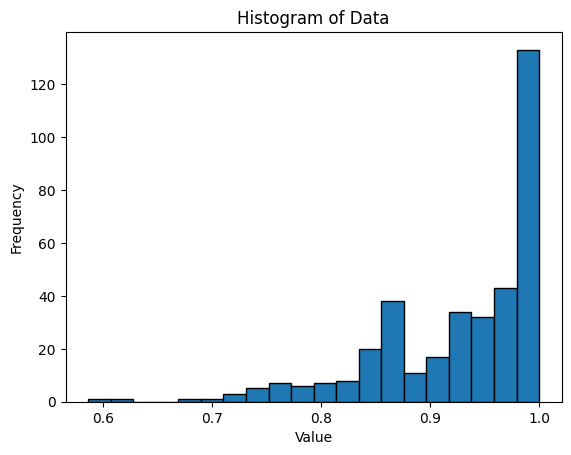

In [15]:
import matplotlib.pyplot as plt

# ヒストグラムをプロットするためのリストデータ

# ヒストグラムの描画
plt.hist(r2_score_vals, bins=20, edgecolor="black")

# グラフのタイトルとラベルを設定
plt.title("Histogram of Data")
plt.xlabel("Value")
plt.ylabel("Frequency")

# グラフを表示
plt.show()